<a href="https://colab.research.google.com/github/A-n-a-s-t-a-s-i-i-a/Python-for-DA-projects/blob/main/Portfolio_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, spearmanr, f_oneway, mannwhitneyu, ttest_ind
import statsmodels.api as sm
import numpy as np

auth.authenticate_user()

client = bigquery.Client(project="data-analytics-mate")

query = """
select
  s.date,
  sp.ga_session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.medium,
  sp.channel,
  acs.account_id,
  a.is_verified,
  a.is_unsubscribed,
  p.category,
  p.name,
  p.price,
  p.short_description
from `DA.session_params` sp
join `DA.session` s
on s.ga_session_id = sp.ga_session_id
left join `DA.account_session` acs
on acs.ga_session_id = sp.ga_session_id
left join `DA.account` a
on a.id = acs.account_id
left join `DA.order` o
on sp.ga_session_id = o.ga_session_id
left join `DA.product` p
on o.item_id = p.item_id
order by date
"""

query_job = client.query(query)
results = query_job.result()


df = results.to_dataframe()

df.head()


,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,medium,channel,account_id,is_verified,is_unsubscribed,category,name,price,short_description
0,2020-11-01,7052560603,(not set),(not set),mobile,Chrome,<Other>,Web,None,<Other>,Paid Search,<NA>,<NA>,<NA>,None,None,NaN,None
1,2020-11-01,6164084975,(not set),(not set),mobile,Safari,iPhone,Web,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-01,542050872,Asia,India,desktop,Edge,Edge,Web,None,referral,Social Search,<NA>,<NA>,<NA>,None,None,NaN,None
3,2020-11-01,1794022887,Asia,India,desktop,Chrome,Chrome,Web,en-us,referral,Paid Search,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-01,1546135823,Asia,Saudi Arabia,desktop,Safari,Safari,Web,en-us,referral,Social Search,654428,1,0,None,None,NaN,None


# Інформація про датасет:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  name               33538 non-null   object 
 16  pr

Загальна кількість колонок - 18, з них:

*  5 числових (ga_session_id, account_id, is_verified, is_unsubscribed, price)
*  1 типу datetime (date)
*  12 категоріальних (continent, country, device, browser, mobile_model_name, operating_system, language, medium, channel, category, name, short_description)


In [ ]:
print(f"Кільість унікальни сессій: {df.ga_session_id.nunique()}")
print(f"Період часу: з {df.date.min()} по {df.date.max()}")
print("Пропущені значення:\n")
print(df.isna().sum())

Кільість унікальни сессій: 349545
Період часу: з 2020-11-01 по 2021-01-31
Пропущені значення:

date                      0
ga_session_id             0
continent                 0
country                   0
device                    0
browser                   0
mobile_model_name         0
operating_system          0
language             114266
medium                    0
channel                   0
account_id           321600
is_verified          321600
is_unsubscribed      321600
category             316007
name                 316007
price                316007
short_description    316007
dtype: int64


Оскільки частина даних була доєднана через left join, деякі колонки мають пропущені значення. Наприклад для полів account_id, is_verified, is_unsubscribed пропущені значення скоріш за все через незареєстрованих користувачів, а поля пов'язані з товаром, мають пропущені значення через відсутність замовлень.

Також є пропущені значення у полі language, там значення були відсутні і в основній таблиці з якої тягнулись ці дані.

# Інформація по континентах та країнах:

## В розрізі продажів:

In [ ]:
sales_df = df[df['price'].notnull()]

top_continents_by_sales = (
    sales_df.groupby('continent')['price']
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
    .tolist()
)

top_countries_by_sales = (
    sales_df.groupby('country')['price']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

print(f"Топ 3 континента з продажу:\n {top_continents_by_sales}")
print(f"Топ 5 країн з продажу:\n {top_countries_by_sales}")

Топ 3 континента з продажу:
 ['Americas', 'Asia', 'Europe']
Топ 5 країн з продажу:
 ['United States', 'India', 'Canada', 'United Kingdom', 'France']


## В розрізі замовлень:

In [ ]:
# sales_df = df[df['price'].notnull()]

top_continents_by_orders = (
    sales_df.groupby('continent')
    .size()
    .sort_values(ascending=False)
    .head(3)
    .index
    .tolist()
)

top_countries_by_orders = (
    sales_df.groupby('country')
    .size()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)
print(f"Топ 3 континента з замовлень:\n {top_continents_by_orders}")
print(f"Топ 5 країн з замовлень:\n {top_countries_by_orders}")

Топ 3 континента з замовлень:
 ['Americas', 'Asia', 'Europe']
Топ 5 країн з замовлень:
 ['United States', 'India', 'Canada', 'United Kingdom', 'France']


## В розрізі зареєстрованих користувачів:

In [ ]:
registered_df = df[df['account_id'].notnull()]

top_continents_by_users = (
    registered_df.groupby('continent')
    .size()
    .sort_values(ascending=False)
    .head(3)
    .index
    .tolist()
)

top_countries_by_users = (
    registered_df.groupby('country')
    .size()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

print(f"Топ 3 континента по кількості зареєстрованих користувачів:\n {top_continents_by_users}")
print(f"Топ 5 країн по кількості зареєстрованих користувачів:\n {top_countries_by_users}")

Топ 3 континента по кількості зареєстрованих користувачів:
 ['Americas', 'Asia', 'Europe']
Топ 5 країн по кількості зареєстрованих користувачів:
 ['United States', 'India', 'Canada', 'United Kingdom', 'France']


З цих даних видно що найбільш активні користувачі в країнах:
*  United States
*  India
*  Canada
*  United Kingdom
*  France

# Інформація по категоріях:

In [ ]:
# sales_df = df[df['price'].notnull()]

top_categories_by_sales = (
    sales_df.groupby('category')['price']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

top_categories_by_orders = (
    sales_df.groupby('category')
    .size()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

avg_check_by_category = (
    sales_df.groupby('category')['price']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

print(f"Топ 5 категорій з продажу:\n {top_categories_by_sales}")
print(f"Топ 5 категорій з замовлень:\n {top_categories_by_orders}")
print(f"Топ 5 категорій за середнім чеком:\n {avg_check_by_category}")

Топ 5 категорій з продажу:
 ['Sofas & armchairs', 'Chairs', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards']
Топ 5 категорій з замовлень:
 ['Bookcases & shelving units', 'Chairs', 'Sofas & armchairs', 'Tables & desks', 'Beds']
Топ 5 категорій за середнім чеком:
 ['Sofas & armchairs', 'Beds', 'Chairs', 'Cabinets & cupboards', 'Outdoor furniture']


# Інформація по каналам трафіку:

In [ ]:
# sales_df = df[df['price'].notnull()]
#registered_df = df[df['account_id'].notnull()]

revenue_by_channel = (
    sales_df.groupby('channel')['price']
    .sum()
    .sort_values(ascending=False)
)

orders_by_channel = (
    sales_df.groupby('channel')
    .size()
    .sort_values(ascending=False)
)

avg_check_by_channel = (
    sales_df.groupby('channel')['price']
    .mean()
    .sort_values(ascending=False)
)

registered_users_by_channel = (
    registered_df.groupby('channel')
    .size()
    .sort_values(ascending=False)
)

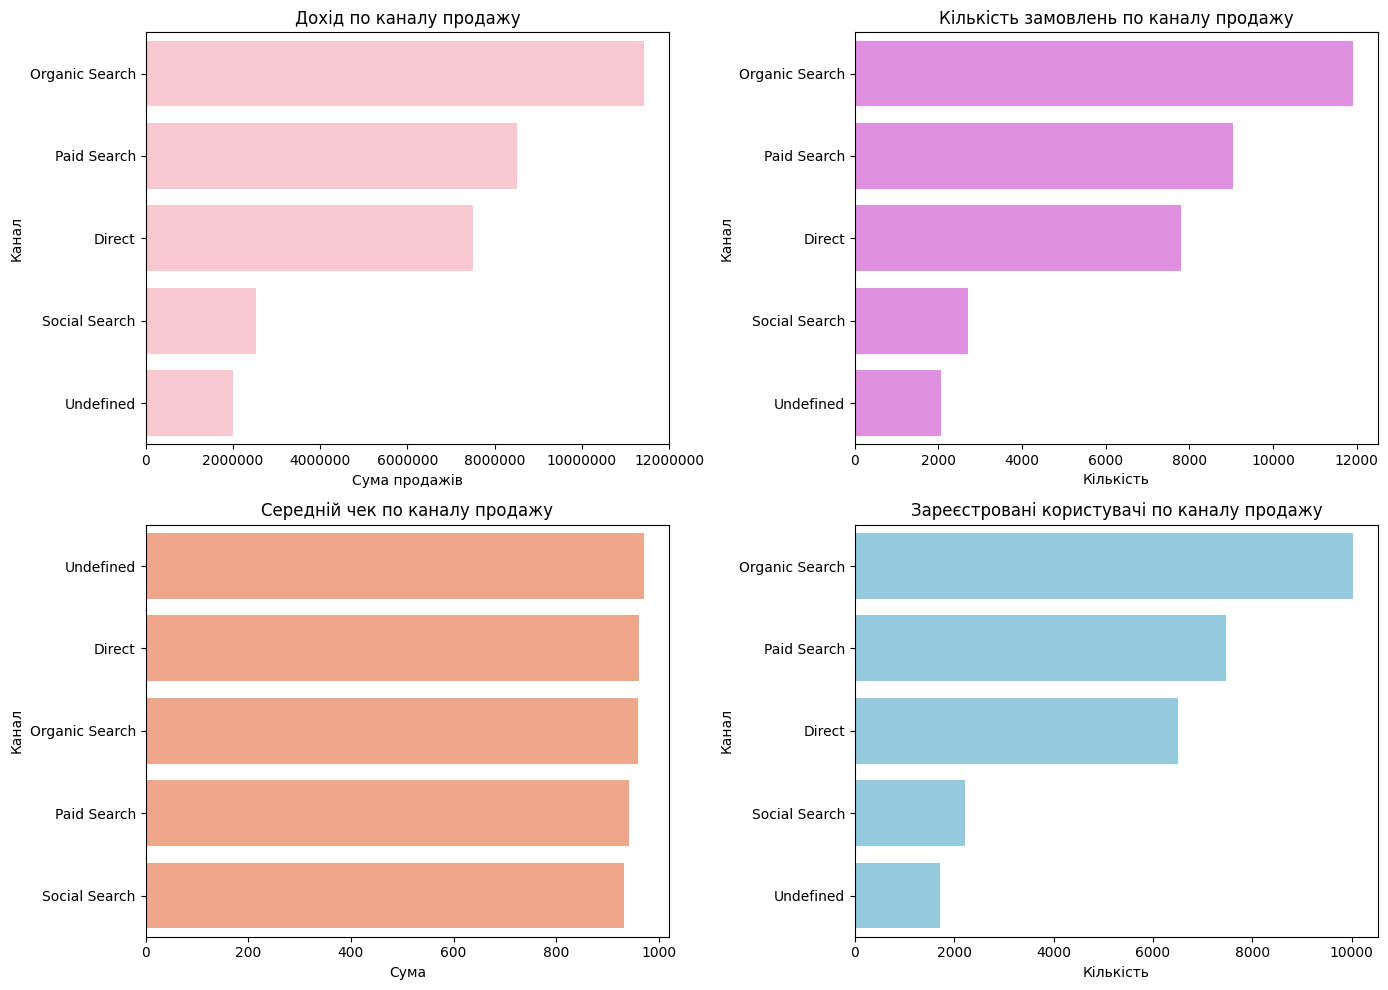

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(
    x=revenue_by_channel.values,
    y=revenue_by_channel.index,
    color='pink',
    ax=ax[0, 0],
    errorbar=None
)
ax[0, 0].set_title('Дохід по каналу продажу')
ax[0, 0].set_xlabel('Сума продажів')
ax[0, 0].set_ylabel('Канал')
ax[0, 0].ticklabel_format(style='plain', axis='x')


sns.barplot(
    x=orders_by_channel.values,
    y=orders_by_channel.index,
    color='violet',
    ax=ax[0, 1],
    errorbar=None
)
ax[0, 1].set_title('Кількість замовлень по каналу продажу')
ax[0, 1].set_xlabel('Кількість')
ax[0, 1].set_ylabel('Канал')
ax[0, 1].ticklabel_format(style='plain', axis='x')


sns.barplot(
    x=avg_check_by_channel.values,
    y=avg_check_by_channel.index,
    color='lightsalmon',
    ax=ax[1, 0],
    errorbar=None
)
ax[1, 0].set_title('Середній чек по каналу продажу')
ax[1, 0].set_xlabel('Сума')
ax[1, 0].set_ylabel('Канал')
ax[1, 0].ticklabel_format(style='plain', axis='x')


sns.barplot(
    x=registered_users_by_channel.values,
    y=registered_users_by_channel.index,
    color='skyblue',
    ax=ax[1, 1],
    errorbar=None
)
ax[1, 1].set_title('Зареєстровані користувачі по каналу продажу')
ax[1, 1].set_xlabel('Кількість')
ax[1, 1].set_ylabel('Канал')
ax[1, 1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()


# Загальна динаміка продажів по датах

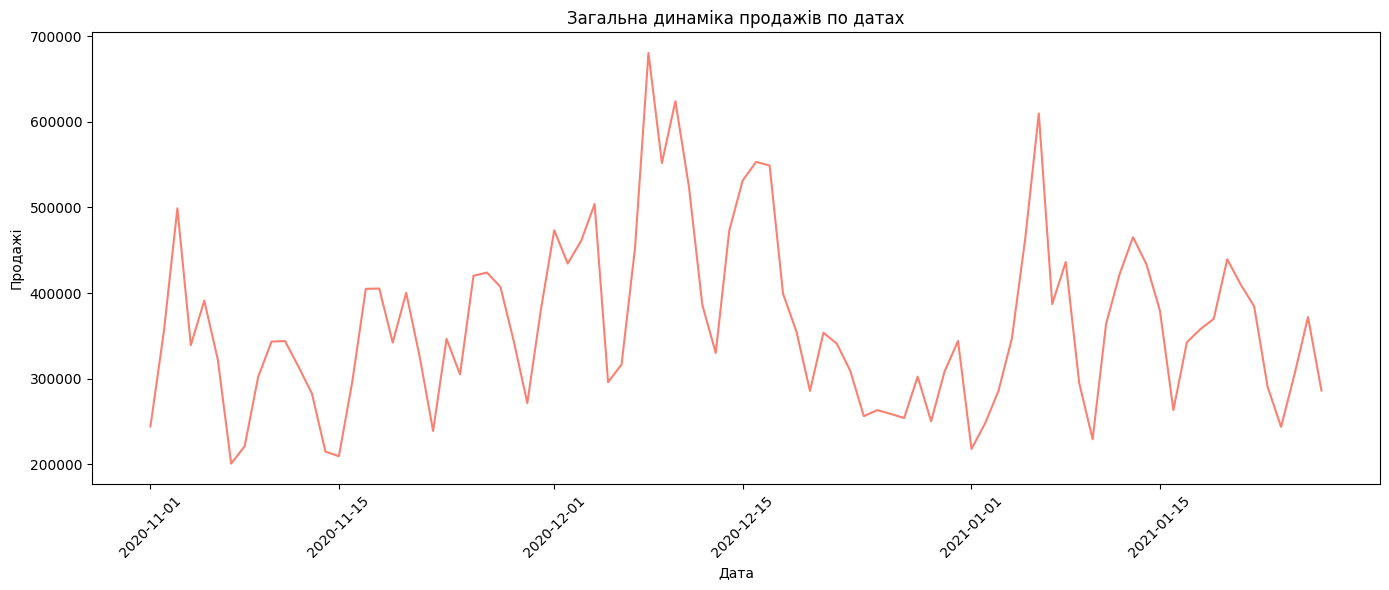

In [ ]:
# sales_df = df[df['price'].notnull()]

plt.figure(figsize=(14, 6))
sales_by_date = sales_df.groupby('date')['price'].sum()

sns.lineplot(x=sales_by_date.index, y=sales_by_date.values, color='salmon')
plt.title('Загальна динаміка продажів по датах')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

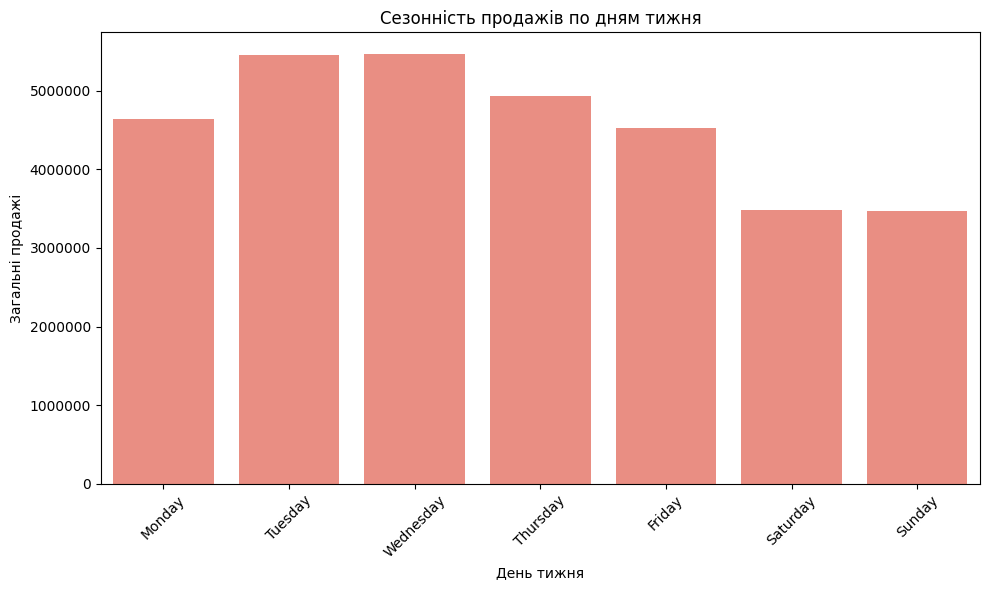

In [ ]:
# sales_df = df[df['price'].notnull()]

sales_df.loc[:, 'date'] = pd.to_datetime(sales_df['date'])
sales_df.loc[:, 'day_of_week'] = sales_df['date'].dt.day_name()


sales_by_dayofweek = (
    sales_df.groupby('day_of_week')['price']
    .sum()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
)


plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_dayofweek.index, y=sales_by_dayofweek.values, color='salmon')
plt.title('Сезонність продажів по дням тижня')
plt.xlabel('День тижня')
plt.ylabel('Загальні продажі')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

Найбільші продажі припадають на вівторок та середу, а найменші на суботу та неділю.

# Динаміка продажів в Америці, Азії та Європі

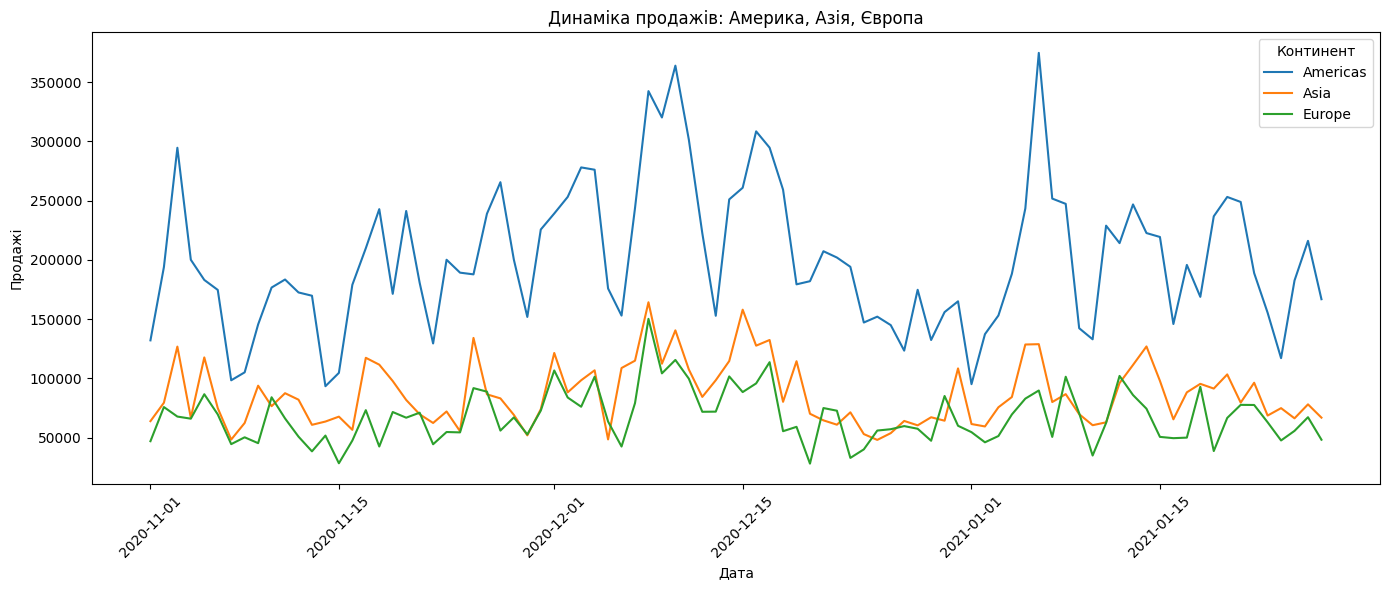

In [ ]:
# sales_df = df[df['price'].notnull()]

continent_sales = (
    sales_df[sales_df['continent'].isin(['Americas', 'Asia', 'Europe'])]
    .groupby(['date', 'continent'])['price']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.lineplot(data=continent_sales, x='date', y='price', hue='continent')
plt.title('Динаміка продажів: Америка, Азія, Європа')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend(title='Континент')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Динаміка продажів за каналами трафіку

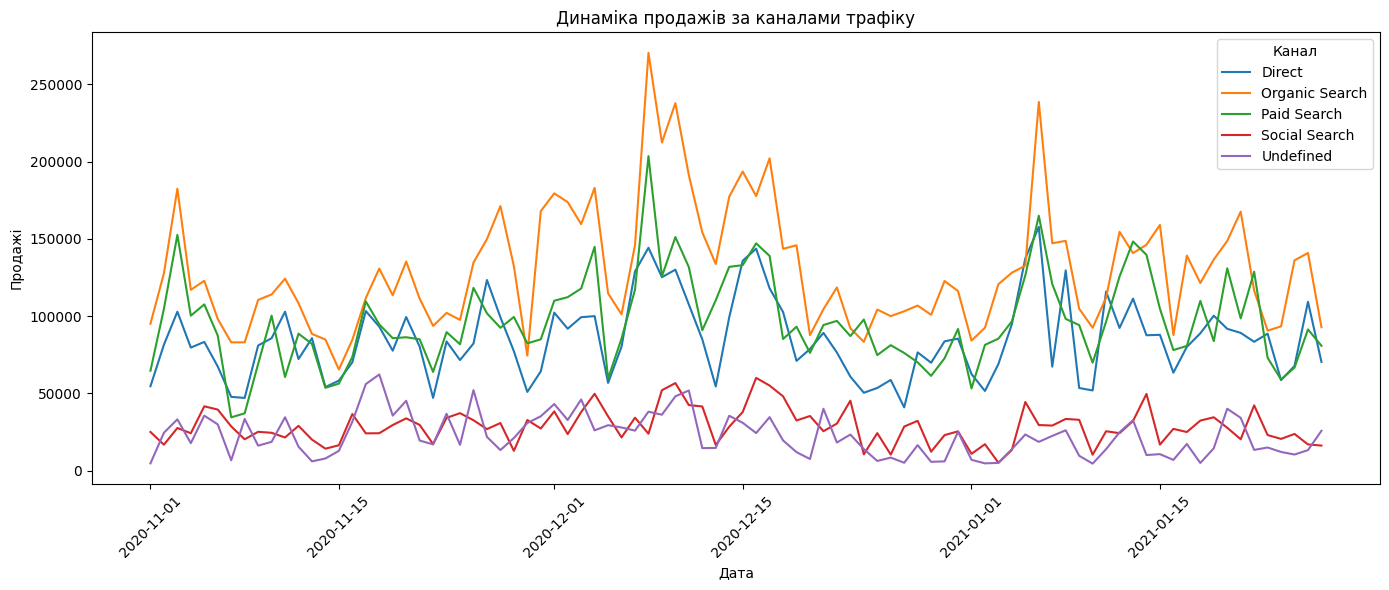

In [ ]:
# sales_df = df[df['price'].notnull()]

channel_sales = sales_df.groupby(['date', 'channel'])['price'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=channel_sales, x='date', y='price', hue='channel')
plt.title('Динаміка продажів за каналами трафіку')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend(title='Канал')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Динаміка продажів за типами девайсів

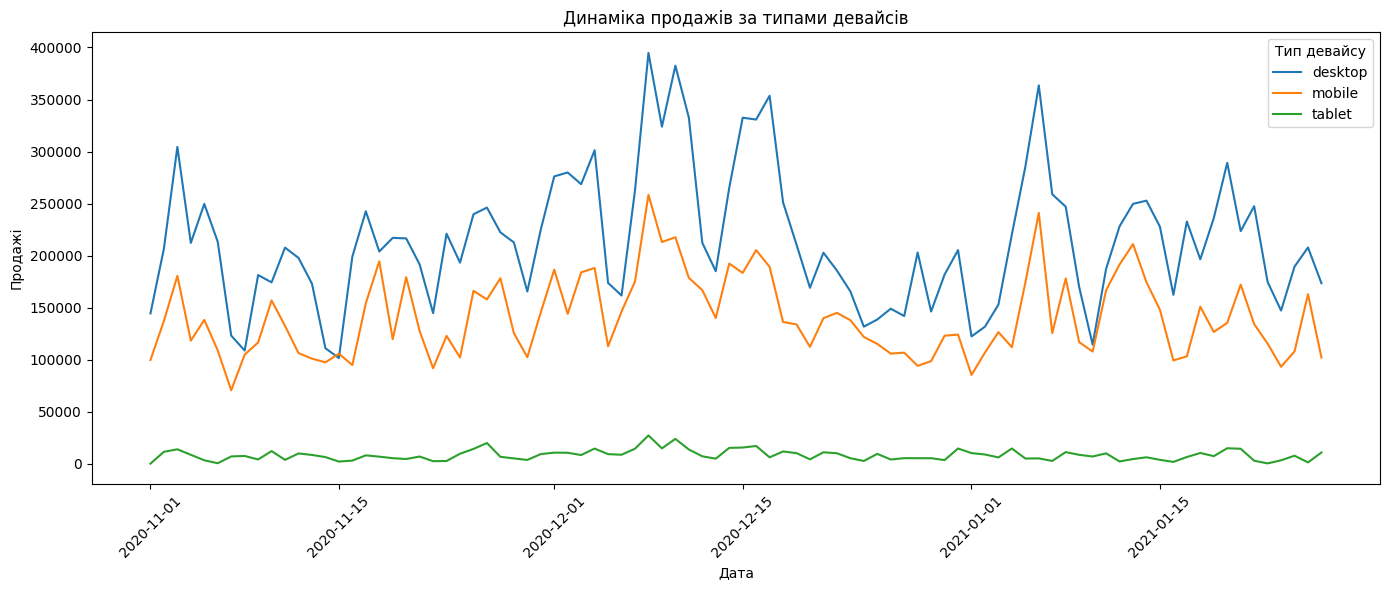

In [ ]:
# sales_df = df[df['price'].notnull()]

device_sales = sales_df.groupby(['date', 'device'])['price'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=device_sales, x='date', y='price', hue='device')
plt.title('Динаміка продажів за типами девайсів')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend(title='Тип девайсу')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Кількість сесій у розрізі каналів трафіку та типів девайсів

In [ ]:
filtered_sessions = df[df['channel'].notna() & df['device'].notna()]


sessions_pivot = pd.pivot_table(
    filtered_sessions,
    index='channel',
    columns='device',
    values='ga_session_id',
    aggfunc='nunique',
    fill_value=0
)


display(sessions_pivot)

device,desktop,mobile,tablet
channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Undefined,12527,8486,470


# Загальні продажі за категоріями товарів (топ-5) у топ-5 країнах

In [ ]:
# sales_df = df[df['price'].notnull()]

filtered_sales = sales_df[sales_df['category'].isin(top_categories_by_sales) & sales_df['country'].isin(top_countries_by_sales)]


sales_by_category_country = pd.pivot_table(
    filtered_sales,
    index='category',
    columns='country',
    values='price',
    aggfunc='sum',
    fill_value=0
)

display(sales_by_category_country)


country,Canada,France,India,United Kingdom,United States
category,,,,,
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


# Середній чек по типу девайса та континенту

In [ ]:
# sales_df = df[df['price'].notnull()]

avg_check_pivot = pd.pivot_table(
    sales_df[sales_df['device'].notna() & sales_df['continent'].notna() & ~sales_df['continent'].isin(['(not set)'])],
    index='device',
    columns='continent',
    values='price',
    aggfunc='mean',
    fill_value=0
).round(2)

display(avg_check_pivot)

continent,Africa,Americas,Asia,Europe,Oceania
device,,,,,
desktop,1030.02,962.17,940.15,955.43,1039.48
mobile,907.48,936.26,971.46,935.09,942.73
tablet,987.14,966.60,1110.69,978.02,847.78


# Кількість замовлень по категорії товару та каналу трафіку

In [ ]:
# sales_df = df[df['price'].notnull()]

orders_pivot = pd.pivot_table(
    sales_df[sales_df['category'].notna() & sales_df['channel'].notna()],
    index='category',
    columns='channel',
    values='price',
    aggfunc='count',
    fill_value=0
)

display(orders_pivot)

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
category,,,,,
Bar furniture,259,397,276,87,73
Beds,666,1063,788,220,189
Bookcases & shelving units,1713,2759,2049,623,486
Cabinets & cupboards,562,803,630,191,132
Café furniture,76,141,97,23,22
Chairs,1373,2067,1695,483,334
Chests of drawers & drawer units,347,497,393,115,100
Children's furniture,421,613,424,140,104
Nursery furniture,92,136,109,31,26


# Кореляція між кількістю сесій та загальними продажами

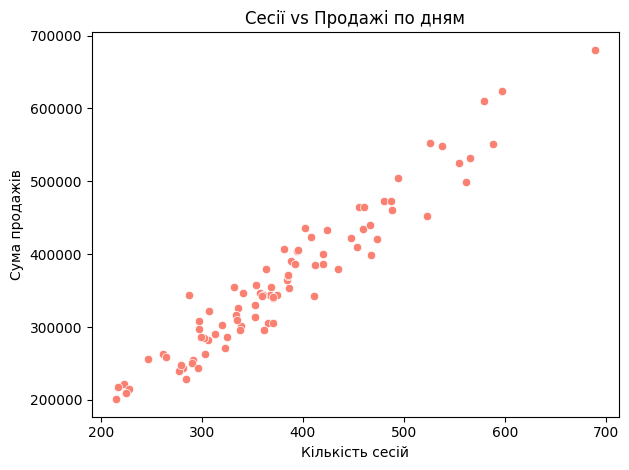

In [ ]:
# sales_df = df[df['price'].notnull()]

daily_sessions = sales_df.groupby("date")["ga_session_id"].nunique()
daily_sales = sales_df.groupby("date")["price"].sum()

daily = pd.DataFrame({
    "sessions": daily_sessions,
    "sales": daily_sales
}).fillna(0)

sns.scatterplot(data=daily, x="sessions", y="sales", color='salmon')
plt.title("Сесії vs Продажі по дням")
plt.xlabel("Кількість сесій")
plt.ylabel("Сума продажів")
plt.tight_layout()
plt.show()

Точковий графік розсіювання вказує на прямий кореляційний зв’язок між кількістю сесій і сумою продажів. Наступним кроком буде перевірка даних на нормальність, після того - розрахунок коефіцієнта кореляції та перевірка його статистичної значущості.

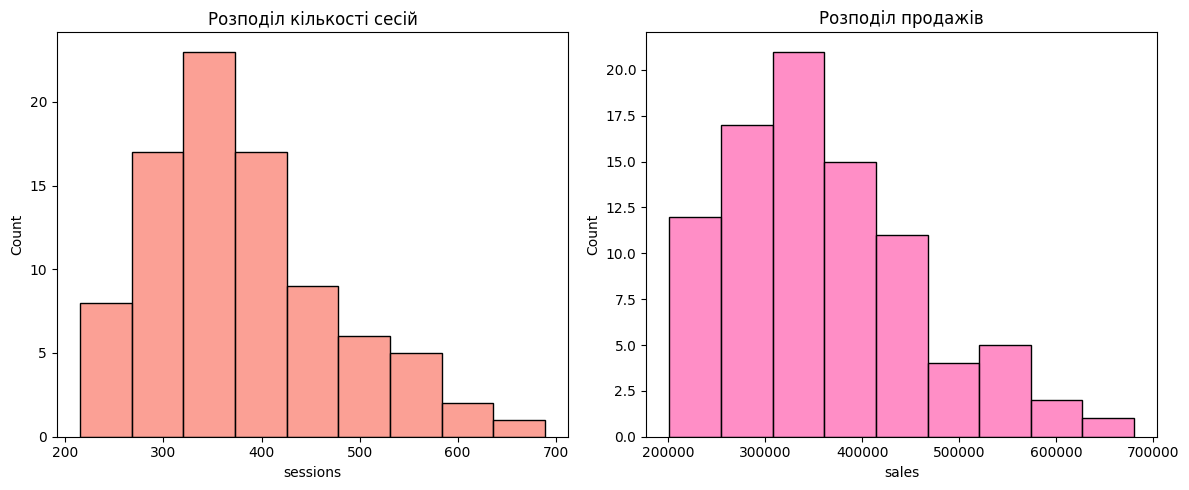

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(daily['sessions'], color='salmon')
plt.title('Розподіл кількості сесій')

plt.subplot(1, 2, 2)
sns.histplot(daily['sales'], color='hotpink')
plt.title('Розподіл продажів')

plt.tight_layout()
plt.show()

Розподіл даних не є  нормальним, тому краще використовувати коефіцієнт Спірмена.

In [ ]:
print(f"Test statistic and p-value: {spearmanr(daily['sessions'], daily['sales'])}")
spearmanr_corr = daily['sessions'].corr(daily['sales'], method="spearman")
print(f"Spearmanr Correlation: {spearmanr_corr}")

Test statistic and p-value: SignificanceResult(statistic=np.float64(0.950959845605782), pvalue=np.float64(1.346332900826623e-45))
Spearmanr Correlation: 0.950959845605782


Коефіцієнт кореляції вказує на дуже сильний монотонний зв’язок, а p-value неймовірно малий < 0.05 — це означає, що Кореляція статистично значуща.

# Кореляція продажів на різних континентах

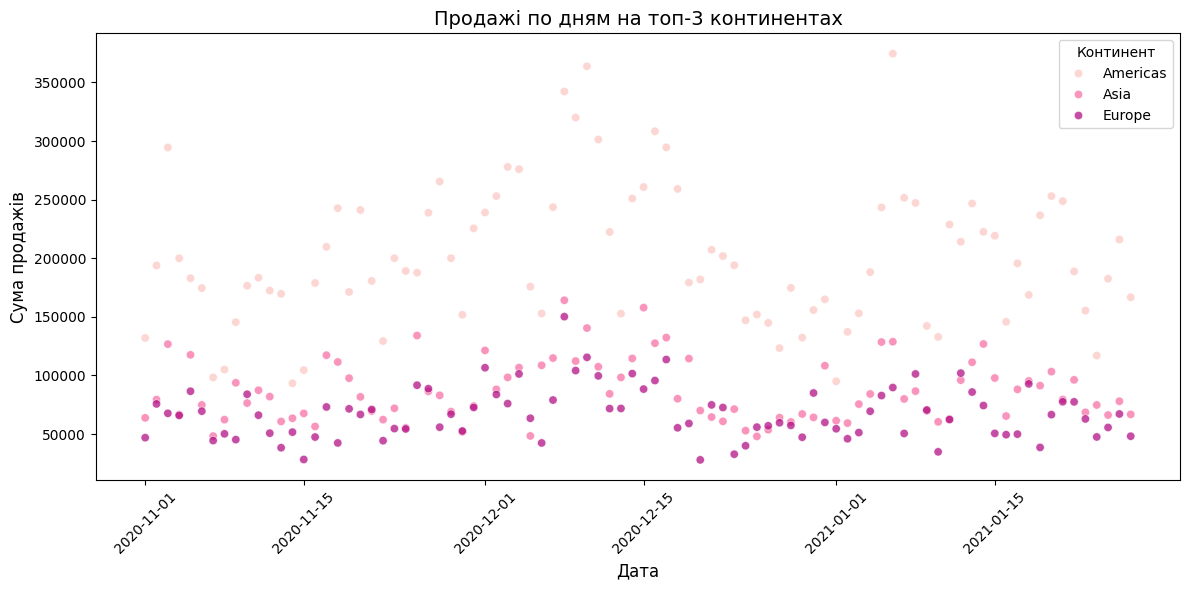

In [ ]:
# continent_sales = (
#     sales_df[sales_df['continent'].isin(['Americas', 'Asia', 'Europe'])]
#     .groupby(['date', 'continent'])['price']
#     .sum()
#     .reset_index()
# )

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=continent_sales,
    x='date',
    y='price',
    hue='continent',
    palette='RdPu',
    alpha=0.7
)
plt.title('Продажі по дням на топ-3 континентах', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сума продажів', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Континент')
plt.tight_layout()
plt.show()

In [ ]:
# sales_df = df[df['price'].notnull()]

americas = sales_df[sales_df['continent'] == 'Americas'].groupby('date')['price'].sum()
asia = sales_df[sales_df['continent'] == 'Asia'].groupby('date')['price'].sum()
europe = sales_df[sales_df['continent'] == 'Europe'].groupby('date')['price'].sum()

corr_am_as, p_am_as = spearmanr(americas, asia)
print(f"Americas-Asia: коефіцієнт = {corr_am_as}, p-value = {p_am_as}")

corr_am_eu, p_am_eu = spearmanr(americas, europe)
print(f"Americas-Europe: коефіцієнт = {corr_am_eu}, p-value = {p_am_eu}")

corr_as_eu, p_as_eu = spearmanr(asia, europe)
print(f"Asia-Europe: коефіцієнт = {corr_as_eu}, p-value = {p_as_eu}")

Americas-Asia: коефіцієнт = 0.6685393258426968, p-value = 1.1001059722381636e-12
Americas-Europe: коефіцієнт = 0.6258849635447854, p-value = 7.009052955139405e-11
Asia-Europe: коефіцієнт = 0.6082209150787222, p-value = 3.2731384105062476e-10


Аналіз показав, що між продажами в Америці, Азії та Європі існує чіткий зв'язок. Коли зростають продажі в одному регіоні - вони зростають і в інших. Це не випадковість, а статистично підтверджена закономірність.

Найсильніша залежність спостерігається між Америкою та Азією, але всі три регіони тісно пов'язані між собою. Такі результати свідчать, що на продажі в цих регіонах впливають загальні глобальні фактори, а не лише місцеві умови.

# Кореляція продажів за різними каналами трафіку

In [ ]:
# sales_df = df[df['price'].notnull()]

channels = sales_df['channel'].unique()

channel_sales = [sales_df[sales_df['channel'] == channel]['price'].values for channel in channels]

f_stat, p_value = f_oneway(*channel_sales)

print(f"F-stat: {f_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("\nВисновок: Існує статистично значуща різниця у продажах між каналами трафіку (p < 0.05).")
else:
    print("\nВисновок: Немає статистично значущої різниці у продажах між каналами трафіку (p > 0.05).")

print("\nСередні продажі по каналах трафіку:")
print(sales_df.groupby('channel')['price'].mean().round(2))

F-stat: 0.5823699003906978
P-value: 0.6754091982671084

Висновок: Немає статистично значущої різниці у продажах між каналами трафіку (p > 0.05).

Середні продажі по каналах трафіку:
channel
Direct            960.89
Organic Search    959.08
Paid Search       941.28
Social Search     932.29
Undefined         971.59
Name: price, dtype: float64


# Кореляція продажів за топ-5 категоріями товарів

In [ ]:
# sales_df = df[df['price'].notnull()]

filtered_data = sales_df[sales_df['category'].isin(top_categories_by_sales)]
category_sales = []
for category in top_categories_by_sales:
    category_sales.append(filtered_data[filtered_data['category'] == category]['price'].values)

f_stat, p_value = f_oneway(*category_sales)


print(f"F-статистика: {f_stat}")
print(f"P-значення: {p_value}")

if p_value < 0.05:
    print("\nВисновок: Існує статистично значуща різниця у продажах між топ-5 категоріями (p < 0.05).")
else:
    print("\nВисновок: Немає статистично значущої різниці у продажах між топ-5 категоріями (p > 0.05).")

print("\nСередні продажі по топ-5 категоріям:")
print(filtered_data.groupby('category')['price'].mean().round(2))

F-статистика: 969.0868177125053
P-значення: 0.0

Висновок: Існує статистично значуща різниця у продажах між топ-5 категоріями (p < 0.05).

Середні продажі по топ-5 категоріям:
category
Beds                          1681.38
Bookcases & shelving units     477.17
Cabinets & cupboards          1007.98
Chairs                        1032.89
Sofas & armchairs             1950.30
Name: price, dtype: float64


# Продажі за кожну дату зареєстрованих та незареєстрованих користувачів

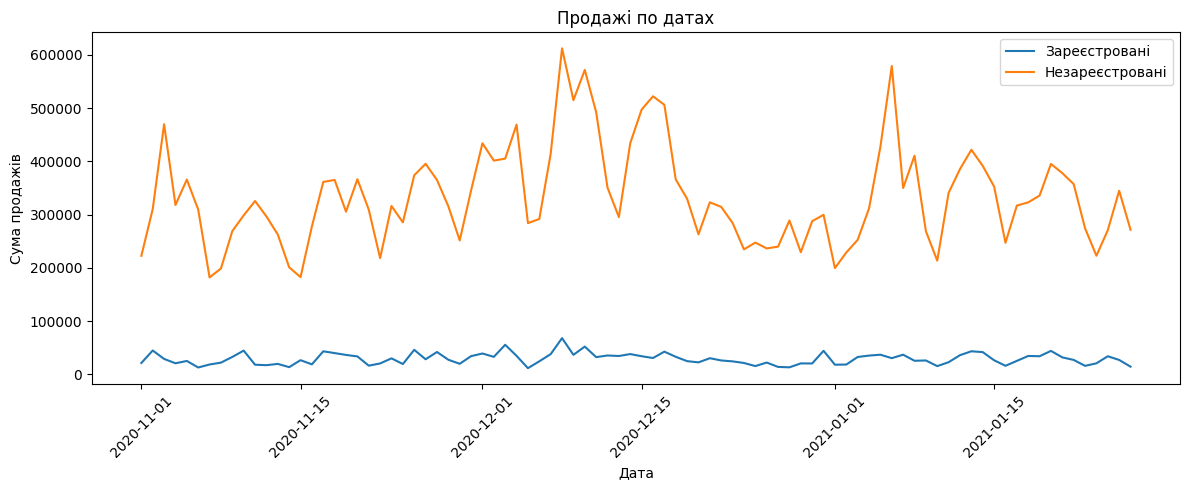

Shapiro Registered: p=0.007295139880540744, Shapiro Unregistered: p=0.0026183359245325936
Mann-Whitney U test: stat=0.0, p=2.2159276950123465e-30


In [ ]:
#registered_df = df[df['account_id'].notnull()]

unregistered_df = df[df["account_id"].isna()]

sales_registered = registered_df.groupby("date")["price"].sum()
sales_unregistered = unregistered_df.groupby("date")["price"].sum()


common_dates = sales_registered.index.intersection(sales_unregistered.index)
sales_registered = sales_registered[common_dates]
sales_unregistered = sales_unregistered[common_dates]

plt.figure(figsize=(12, 5))
plt.plot(sales_registered, label="Зареєстровані")
plt.plot(sales_unregistered, label="Незареєстровані")
plt.legend()
plt.title("Продажі по датах")
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

_, p1 = shapiro(sales_registered)
_, p2 = shapiro(sales_unregistered)
print(f"Shapiro Registered: p={p1}, Shapiro Unregistered: p={p2}")

if p1 < 0.05 or p2 < 0.05:
    stat, p_value = mannwhitneyu(sales_registered, sales_unregistered)
    print(f"Mann-Whitney U test: stat={stat}, p={p_value}")
else:
    stat, p_value = ttest_ind(sales_registered, sales_unregistered)
    print(f"T-test: stat={stat}, p={p_value}")

p-значення обох вибірок < 0.05, значить розподіли не є нормальними, тому використовувався Mann–Whitney U Test.
p-value < 0.05, значить різниця між продажами зареєстрованих та незареєстрованих статистично значуща.

# Кількість сесій за різними каналами трафіку

In [ ]:
channel_session_counts = df.groupby("channel")["ga_session_id"].count().reset_index()

channel_names = df["channel"].dropna().unique()
session_groups_by_channel = [df[df["channel"] == channel]["ga_session_id"] for channel in channel_names]

for name, group in zip(channel_names, session_groups_by_channel):
    print(f"Канал: {name}, унікальних сесій: {group.nunique()}")

anova_result = f_oneway(*session_groups_by_channel)
print(f"stat={anova_result.statistic}, p={anova_result.pvalue}")

Канал: Paid Search, унікальних сесій: 94341
Канал: Undefined, унікальних сесій: 21483
Канал: Social Search, унікальних сесій: 27914
Канал: Direct, унікальних сесій: 81382
Канал: Organic Search, унікальних сесій: 124425
stat=1.4033020827509193, p=0.22995860281947955


Оскільки p-значення > 0.05, немає статистично значущих відмінностей між середніми значеннями кількості сесій у різних каналах.

# Сесії з органічним трафіком у Європі та Америці

In [ ]:
df_europe = df[df["continent"] == "Europe"]
df_america = df[df["continent"] == "Americas"]

organic_europe = df_europe["channel"].eq("Organic Search").sum()
total_europe = len(df_europe)

organic_america = df_america["channel"].eq("Organic Search").sum()
total_america = len(df_america)

events = np.array([organic_europe, organic_america])
sessions = np.array([total_europe, total_america])

z_stat, p_val = sm.stats.proportions_ztest(events, sessions)

print(f"Z-test  (Europe vs Americas): z_statistic={z_stat}, p_value={p_val}")

Z-test  (Europe vs Americas): z_statistic=0.28951412926103953, p_value=0.7721879690501752


Немає статистично значущої різниці у частці органічного трафіку між Європою та Америкою.

# Повний аналіз та висновки  

## Загальна характеристика даних  

У датасеті міститься **349 545 записів**.  
Топ-3 континенти за обсягами продажів: **Америки, Азія, Європа**.  
Топ-5 країн із найбільшими продажами: **США, Індія, Канада, Велика Британія, Франція**.  

## Динаміка продажів за днями тижня  

Найбільші продажі припадають на **вівторок та середу**, а найменші — на **суботу та неділю**. Бажано оптимізувати маркетингові кампанії для найбільш активних днів та стимулювати продажі у вихідні через додаткові акції.  

## Середній чек залежно від пристрою та континенту  

Найвищий середній чек зафіксовано у користувачів таблетів в Азії (1110.69$).

Це більше, ніж у Європі (978.02$) та Америці (966.60$).  

Водночас, продажі через таблети залишаються найнижчими серед усіх типів пристроїв, що свідчить про вузьку аудиторію, але високий рівень витрат.

## Кількість сесій у розрізі каналів трафіку  

Десктоп-користувачі активно використовують **органічний пошук** — найбільша кількість сесій (72 622).  
Мобільні користувачі найчастіше приходять через **платний пошук** (37 034 сесії).  
Трафік із таблетів має найнижчі показники у всіх каналах, що підтверджує слабку залученість цього сегмента.  

## Статистичний аналіз каналів продажів  
Оскільки **p > 0.05**, немає статистично значущої різниці у продажах між каналами. Жоден канал не має суттєвої переваги, тому важливо **балансувати ресурси між усіма джерелами трафіку**.  

## Продажі за категоріями товарів  
Існує **статистично значуща різниця між категоріями** (p < 0.05), що означає **великий розрив у популярності товарів**.  

- Найвищий середній чек у **Sofas & armchairs (1950.30$)**.

- Найменший середній чек у **Bookcases & shelving units (477.17$)**.  

## Кореляція продажів між регіонами  
Висока позитивна кореляція між ринками, особливо між **Америкою та Азією**, означає, що **тренди американського ринку можуть бути адаптовані в інших регіонах**.  



Посилання на [дашборд](https://public.tableau.com/app/profile/anastasiia.paziuka/viz/Portfolioproject_17484462160480/Portfolioproject)